source : https://www.kaggle.com/datasets/nancyalaswad90/diamonds-prices

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import sklearn
import random
import joblib
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

#Preview of data, getting rid of outliers and train test split

In [9]:
df = pd.read_csv("/content/Diamonds Prices2022.csv",index_col=[0])
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53943 entries, 1 to 53943
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53943 non-null  float64
 1   cut      53943 non-null  object 
 2   color    53943 non-null  object 
 3   clarity  53943 non-null  object 
 4   depth    53943 non-null  float64
 5   table    53943 non-null  float64
 6   price    53943 non-null  int64  
 7   x        53943 non-null  float64
 8   y        53943 non-null  float64
 9   z        53943 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


In [11]:
df.describe()

,carat,depth,table,price,x,y,z
count,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000
mean,0.797935,61.749322,57.457251,3932.734294,5.731158,5.734526,3.538730
std,0.473999,1.432626,2.234549,3989.338447,1.121730,1.142103,0.705679
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.000000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [12]:
df.cut.value_counts()

Ideal        21551
Premium      13793
Very Good    12083
Good          4906
Fair          1610
Name: cut, dtype: int64

In [13]:
df.color.value_counts()

G    11292
E     9799
F     9543
H     8304
D     6775
I     5422
J     2808
Name: color, dtype: int64

In [14]:
df.clarity.value_counts()

SI1     13067
VS2     12259
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: clarity, dtype: int64

In [15]:
df = df.loc[df.x > 3]
df = df.loc[df.x < 9]
df = df.loc[df.depth > 55]
df = df.loc[df.depth < 70]
df = df.loc[df.table < 70]
df = df.loc[df.table > 50]
df = df.loc[df.y < 9]
df = df.loc[df.z < 6]
df = df.loc[df.z > 2]
# outliers handling

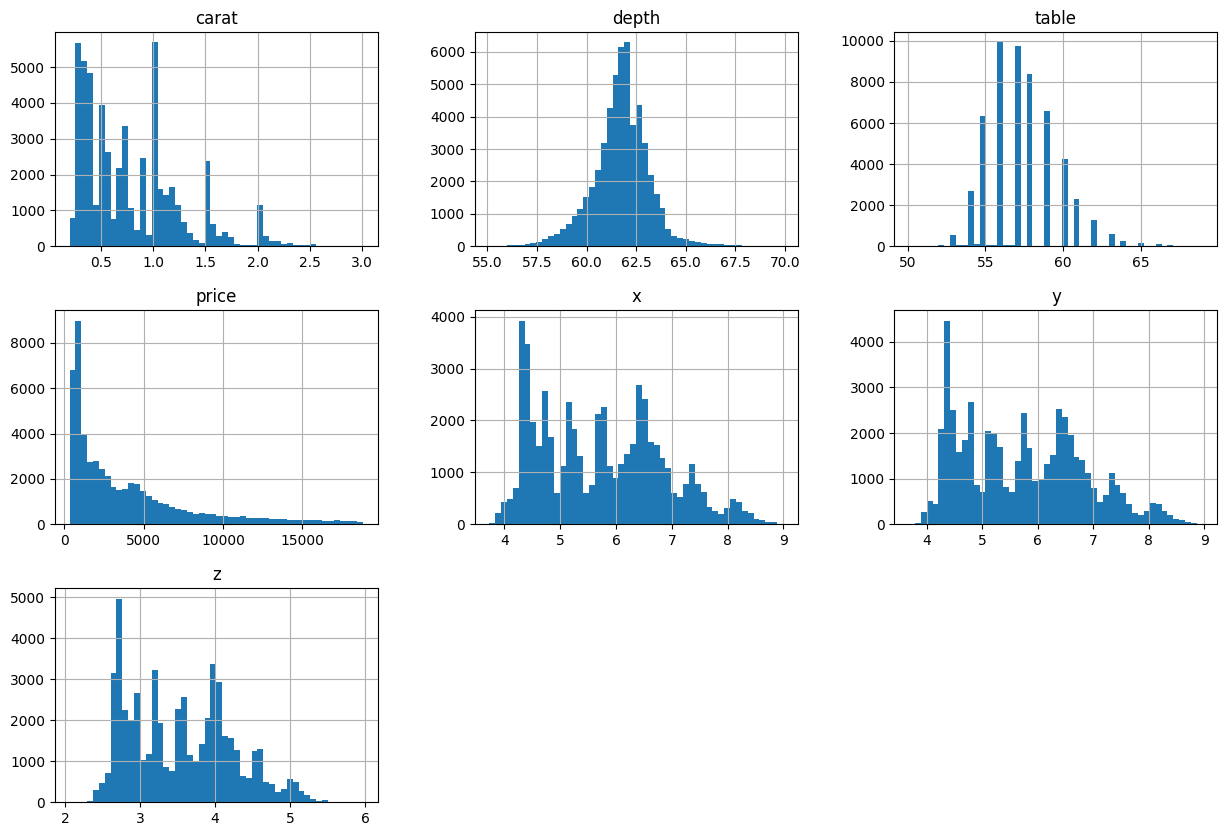

In [16]:
df.hist(bins=50, figsize=(15,10))
plt.show()

In [17]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df,test_size=0.15, random_state = 42)
train_y = train_set.price
train_X = train_set.drop(columns=['price'])
test_y = test_set.price
test_X = test_set.drop(columns=['price'])

# Visualisation, looking for correlation,adding new attribute, encoding categorical attributes, pipeline

Text(0.5, 1.0, 'Mean price by cut')

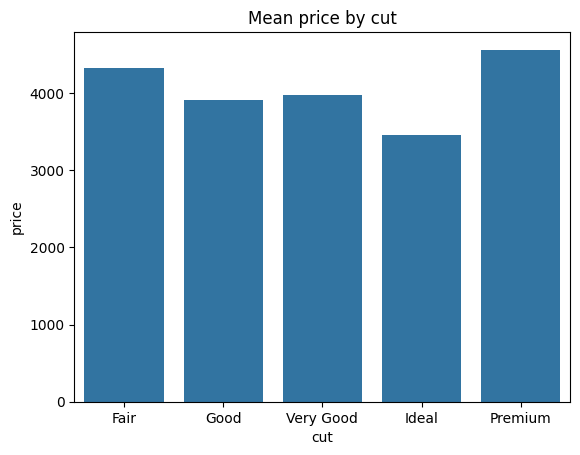

In [18]:
order = ['Fair', 'Good', 'Very Good', 'Ideal', 'Premium']
sns.barplot(df.groupby(by='cut').price.mean().sort_values(ascending=False),order=order)
plt.xticks(rotation=0)
plt.title('Mean price by cut')

Text(0.5, 1.0, 'Mean price by clarity')

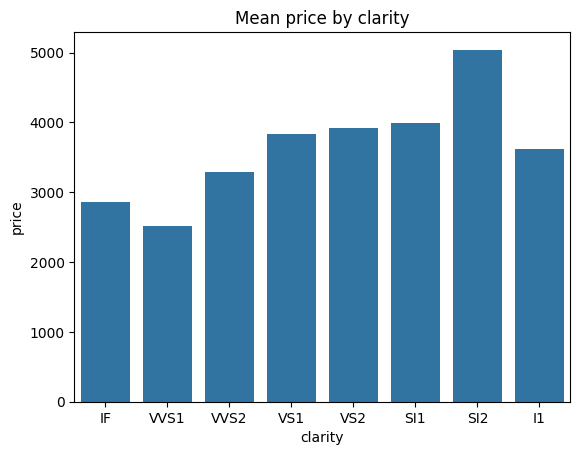

In [19]:
order = ['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1'] # IF - clearest , I1 - least clear
sns.barplot(df.groupby(by='clarity').price.mean().sort_values(ascending=False),order=order)
plt.xticks(rotation=0)
plt.title('Mean price by clarity')

Text(0.5, 1.0, 'Mean price by color')

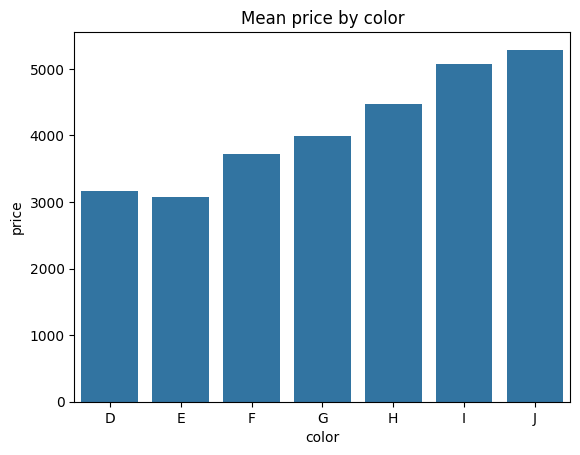

In [20]:
order = ['D', 'E', 'F', 'G', 'H', 'I', 'J'] # d-most colorless , j-most yellow
sns.barplot(df.groupby(by='color').price.mean().sort_values(ascending=False),order=order)
plt.xticks(rotation=0)
plt.title('Mean price by color')

In [21]:
class VolumeAttributeAdder(BaseEstimator, TransformerMixin):
  def __init__(self,add_volume=True):
    self.add_volume = add_volume
  def fit(self,X,y=None):
    return self
  def transform(self,X):
    if self.add_volume:
      volume = X.x * X.y *X.z
      return np.c_[X, volume]
    else:
      return np.c_[X]

In [22]:
class CatEncoder(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  def fit(self,X,y=None):
    return self
  def transform(self,X):
    X = pd.DataFrame(X,columns=df.columns)
    ordinal_encoder = OrdinalEncoder(categories=[['Fair', 'Good', 'Very Good', 'Ideal', 'Premium']])
    X['cut'] = ordinal_encoder.fit_transform(X.loc[:,'cut'].values.reshape(-1,1))

    ordinal_encoder = OrdinalEncoder(categories=[['D', 'E', 'F', 'G', 'H', 'I', 'J']])
    X['color'] = ordinal_encoder.fit_transform(X.loc[:,'color'].values.reshape(-1,1))

    ordinal_encoder = OrdinalEncoder(categories=[['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1']])
    X['clarity'] = ordinal_encoder.fit_transform(X.loc[:,'clarity'].values.reshape(-1,1))

    return np.c_[X]

In [23]:
pipeline = Pipeline([
    ('attribs_adder',VolumeAttributeAdder()),
    ('cat_encoder',CatEncoder()),
    ('std_scaler',StandardScaler())
])
pipeline.fit(df.drop(columns="price"))

Pipeline(steps=[('attribs_adder', VolumeAttributeAdder()),
                ('cat_encoder', CatEncoder()),
                ('std_scaler', StandardScaler())])

In [19]:
# correlation of features and attributes (before scaling)

corr_df = df.copy()
price = corr_df.price.values
volume_adder = VolumeAttributeAdder()
cat_enc = CatEncoder()
corr_df = pd.DataFrame(cat_enc.transform(volume_adder.transform(corr_df.drop(columns=['price']))), columns = ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z','volume'])
corr_df['price'] = price
corr_df = corr_df.astype("int64")
corr_matrix = corr_df.corr()
corr_matrix.price.sort_values(ascending=False)

price      1.000000
volume     0.925565
y          0.878667
x          0.876820
carat      0.853617
z          0.809576
color      0.170910
clarity    0.144247
table      0.128164
cut        0.029112
depth     -0.012486
Name: price, dtype: float64

# Choosing model

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.model_selection import cross_val_score

In [21]:
prepared_train_X = pipeline.transform(train_X)

Average MAE of XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) is : 276.0843738423324 in 10 crossvalidations


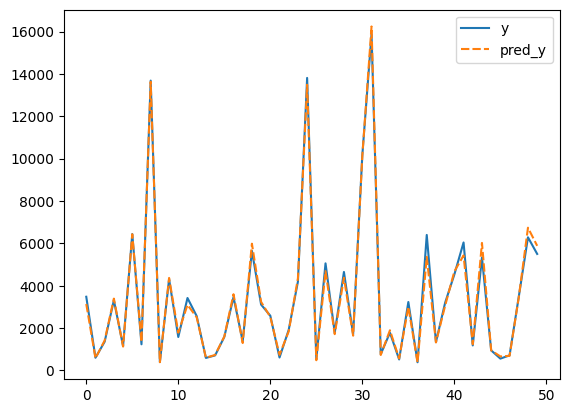

Average MAE of LinearRegression() is : 770.7752615553015 in 10 crossvalidations


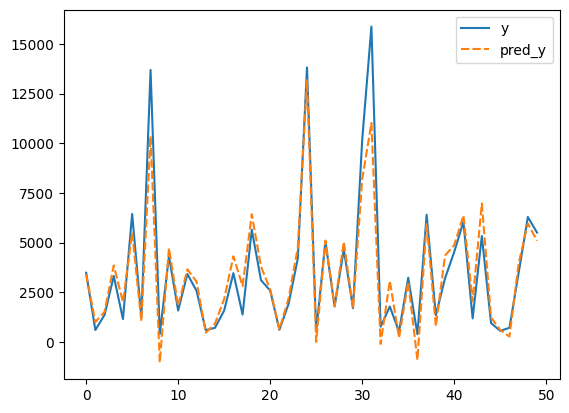

Average MAE of DecisionTreeRegressor() is : 353.7785398836787 in 10 crossvalidations


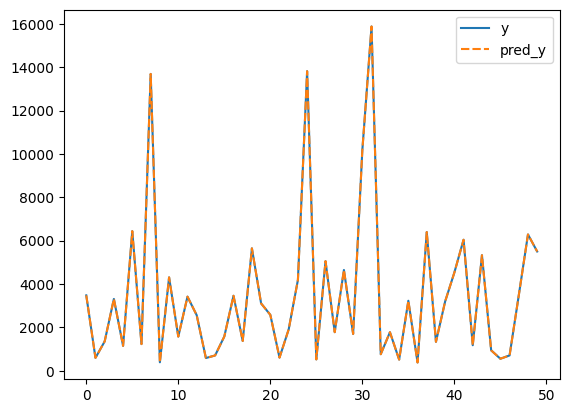

Average MAE of SGDRegressor() is : 773.9764006759609 in 10 crossvalidations


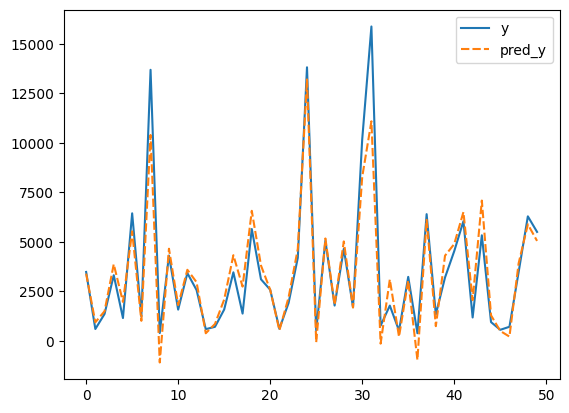

Average MAE of RandomForestRegressor() is : 267.6300572333878 in 10 crossvalidations


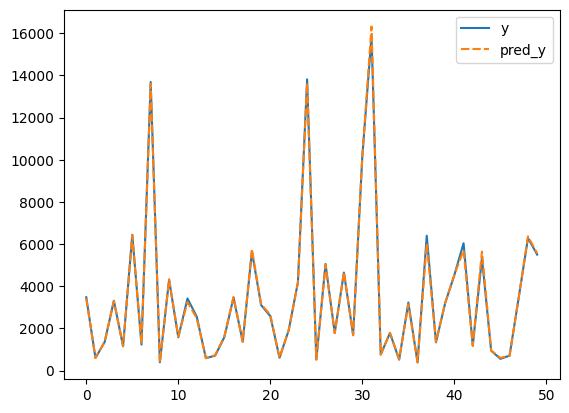

In [27]:
models = [XGBRegressor,LinearRegression, DecisionTreeRegressor, SGDRegressor, RandomForestRegressor]

for m in models:
  model = m()
  scores = cross_val_score(model,prepared_train_X, train_y, scoring="neg_mean_absolute_error", cv=10)
  lin_mae_scores = -scores
  model_mean_mae = lin_mae_scores.mean()

  model.fit(prepared_train_X,train_y)

  pred_y = model.predict(prepared_train_X[3000:3050])
  pred_df = pd.DataFrame(train_y[3000:3050].values,columns=["y"])
  pred_df["pred_y"] = pred_y

  sns.lineplot(pred_df)
  print(f"Average MAE of {model} is : {model_mean_mae} in 10 crossvalidations")
  plt.show()

In [45]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = prepared_train_X.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()


checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               1408      
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dense_8 (Dense)             (None, 256)               65792     
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 166273 (649.50 KB)
Trainable params: 166273 (649.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
NN_model.fit(prepared_train_X, train_y, epochs=100, batch_size=32, validation_split = 0.1, callbacks=callbacks_list)

wights_file = 'Weights-093--257.67502.hdf5'
NN_model.load_weights(wights_file)
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

2/2 [==============================] - 0s 5ms/step
MAE of neural Network is : 167.337626953125


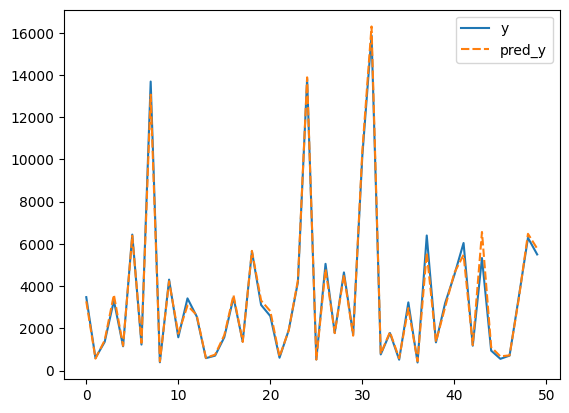

In [ ]:
pred_y = NN_model.predict(prepared_train_X[3000:3050])
pred_df = pd.DataFrame(train_y[3000:3050].values,columns=["y"])
pred_df["pred_y"] = pred_y

sns.lineplot(pred_df)
print(f"MAE of neural Network is : {mean_absolute_error(train_y[3000:3050].values, pred_y)}")
plt.show()

# neaural network on non logarythmic edited target value has 167 MAE on 3000:3050 data

check logarythmic edit on target data

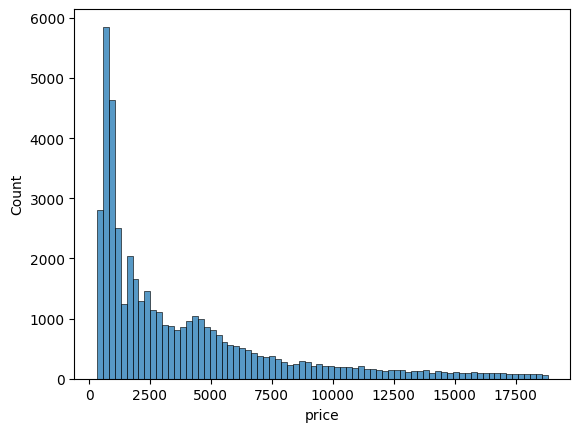

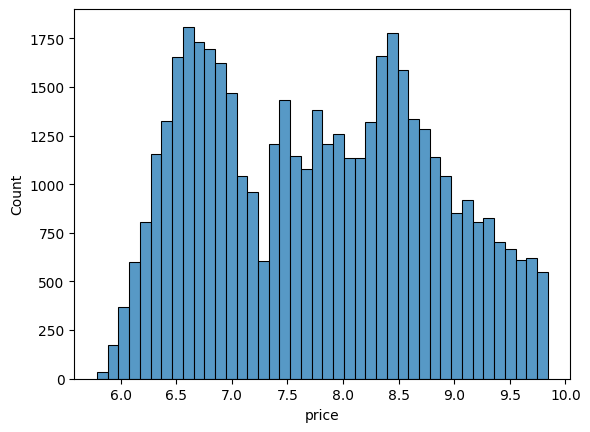

In [29]:
sns.histplot(train_y)
plt.show()
sns.histplot(np.log(train_y))
plt.show()

Average MAE of XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) is : 0.06383252259278946 in 10 crossvalidations
MAE for plot data is : 176.27292846679688


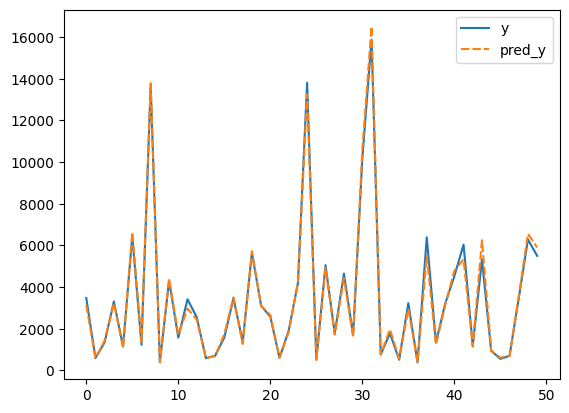

Average MAE of LinearRegression() is : 0.11014957919732027 in 10 crossvalidations
MAE for plot data is : 326.9712064574547


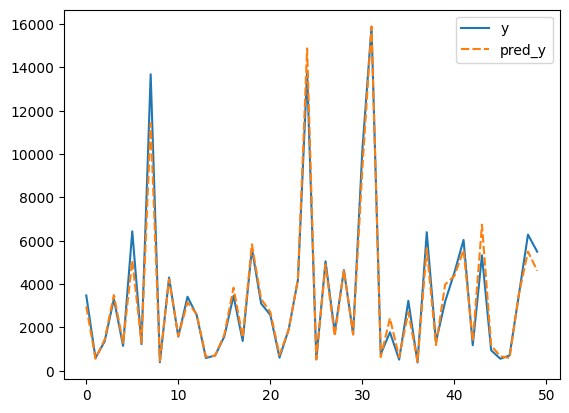

Average MAE of DecisionTreeRegressor() is : 0.0846870850515401 in 10 crossvalidations
MAE for plot data is : 1.1118572729174047e-12


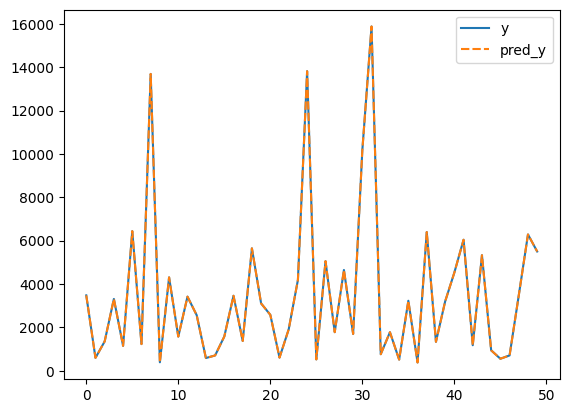

Average MAE of SGDRegressor() is : 0.11163424913187962 in 10 crossvalidations
MAE for plot data is : 318.37104734968926


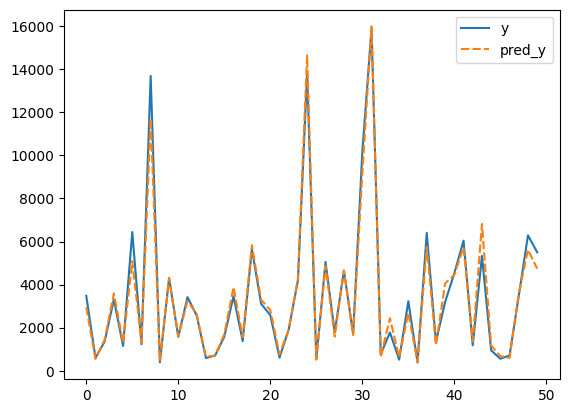

In [28]:
log_train_y = np.log(train_y)

models = [XGBRegressor,LinearRegression, DecisionTreeRegressor, SGDRegressor] #RandomForestRegressor

for m in models:
  model = m()
  scores = cross_val_score(model,prepared_train_X, log_train_y, scoring="neg_mean_absolute_error", cv=10)
  lin_mae_scores = -scores
  model_mean_mae = lin_mae_scores.mean()

  model.fit(prepared_train_X,log_train_y)

  pred_y = np.exp(model.predict(prepared_train_X[3000:3050]))
  pred_df = pd.DataFrame(train_y[3000:3050].values,columns=["y"])
  pred_df["pred_y"] = pred_y

  sns.lineplot(pred_df)
  print(f"Average MAE of {model} is : {model_mean_mae} in 10 crossvalidations")
  print(f"MAE for plot data is : {mean_absolute_error(pred_y,train_y[3000:3050])}")
  plt.show()

  # xgbregressor with logarythmic edit of target value seems to be the best (MAE on 3000:3050 data is 176)

In [32]:
NN_model_log = Sequential()

# The Input Layer :
NN_model_log.add(Dense(128, kernel_initializer='normal',input_dim = prepared_train_X.shape[1], activation='relu'))

# The Hidden Layers :
NN_model_log.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model_log.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model_log.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model_log.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model_log.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model_log.summary()


checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1408      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 166273 (649.50 KB)
Trainable params: 166273 (649.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
NN_model_log.fit(prepared_train_X, log_train_y, epochs=100, batch_size=32, validation_split = 0.1, callbacks=callbacks_list)

wights_file = 'Weights-094--0.06440.hdf5'
NN_model_log.load_weights(wights_file)
NN_model_log.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

2/2 [==============================] - 0s 5ms/step
MAE of neural network for 3000:3050 data is : 227.39788696289062


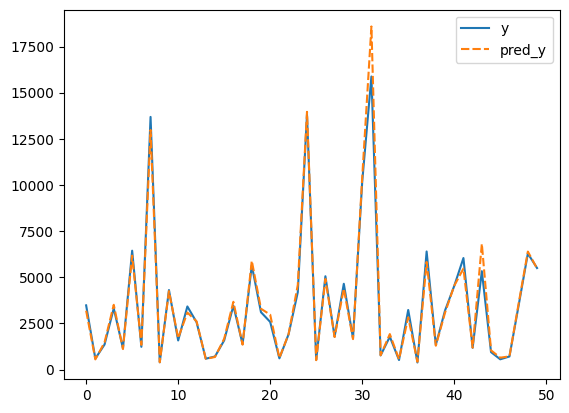

In [38]:
pred_y = np.exp(NN_model_log.predict(prepared_train_X[3000:3050]))
pred_df = pd.DataFrame(train_y[3000:3050].values,columns=["y"])
pred_df["pred_y"] = pred_y

sns.lineplot(pred_df)
print(f"MAE of neural network for 3000:3050 data is : {mean_absolute_error(train_y[3000:3050].values, pred_y)}")
plt.show()

# neaural network with logarythmic edited target value has 227 MAE on 3000:3050 data

check for droping uncorrelated features

In [68]:
prepared_train_X_only_imp_feat = pd.DataFrame(pipeline.transform(train_X)).drop(columns=[1,4]).values

Average MAE of XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) is : 0.06474802583869335 in 10 crossvalidations
MAE for plot data is : 161.333486328125


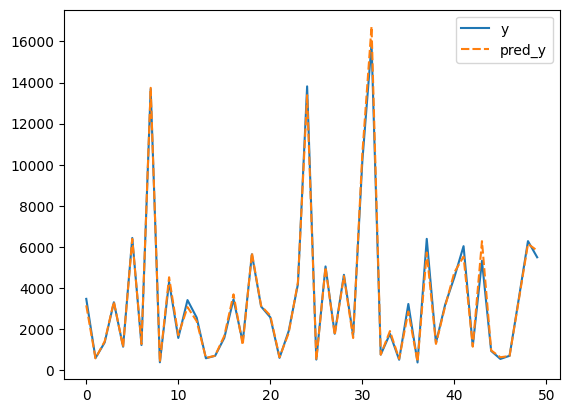

In [69]:
log_train_y = np.log(train_y)

models = [XGBRegressor]

for m in models:
  model = m()
  scores = cross_val_score(model,prepared_train_X_only_imp_feat, log_train_y, scoring="neg_mean_absolute_error", cv=10)
  lin_mae_scores = -scores
  model_mean_mae = lin_mae_scores.mean()

  model.fit(prepared_train_X_only_imp_feat,log_train_y)

  pred_y = np.exp(model.predict(prepared_train_X_only_imp_feat[3000:3050]))
  pred_df = pd.DataFrame(train_y[3000:3050].values,columns=["y"])
  pred_df["pred_y"] = pred_y

  sns.lineplot(pred_df)
  print(f"Average MAE of {model} is : {model_mean_mae} in 10 crossvalidations")
  print(f"MAE for plot data is : {mean_absolute_error(pred_y,train_y[3000:3050])}")
  plt.show()

  #avg mae with teorethically uncorrelated features is lower than with them, best option is to keep this features

looking for best hiperparams

In [39]:
from sklearn.model_selection import GridSearchCV

gsc = GridSearchCV(
            estimator=XGBRegressor(),
            param_grid={"estimator__learning_rate": (0.05, 0.10, 0.15)},
            cv=10, scoring='neg_mean_absolute_error', verbose=0, n_jobs=-1)

grid_result = gsc.fit(prepared_train_X, log_train_y)
print(grid_result.best_params_)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [10:24:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "estimator__learning_rate" } are not used.

  warnings.warn(smsg, UserWarning)


{'estimator__learning_rate': 0.05}


In [40]:
grid_result.best_params_

{'estimator__learning_rate': 0.05}

# Checking the best models on test data & save them

253/253 [==============================] - 1s 2ms/step
MAE for all test data is 284.0986832188727
MAE of Neaural Network trained on logarythmic transformed data for plot below is : 244.72742431640626


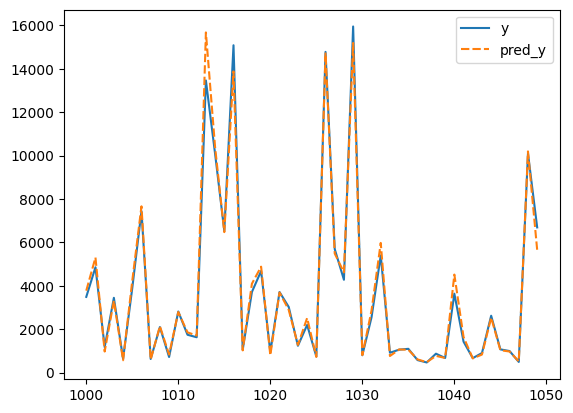

MAE of Neaural Network trained on logarythmic transformed data for plot below is : 287.0962170410156


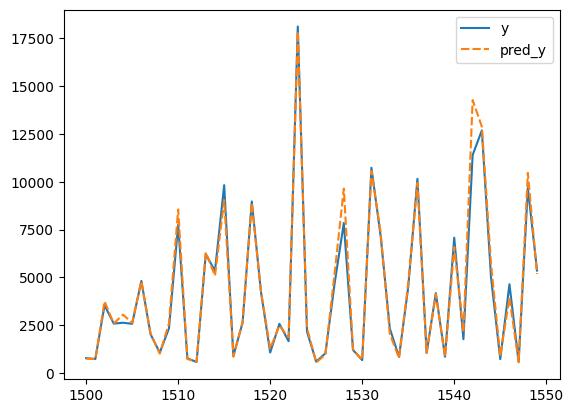

MAE of Neaural Network trained on logarythmic transformed data for plot below is : 229.14536315917968


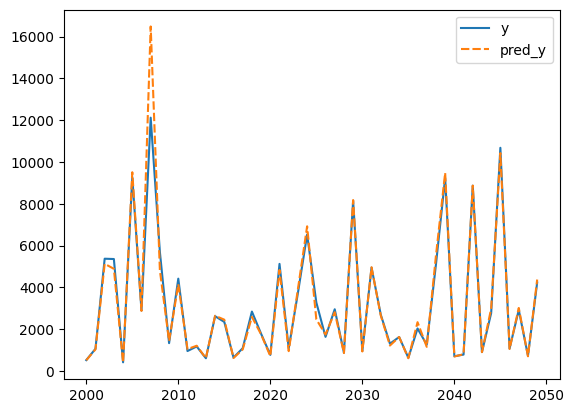

MAE of Neaural Network trained on logarythmic transformed data for plot below is : 331.028369140625


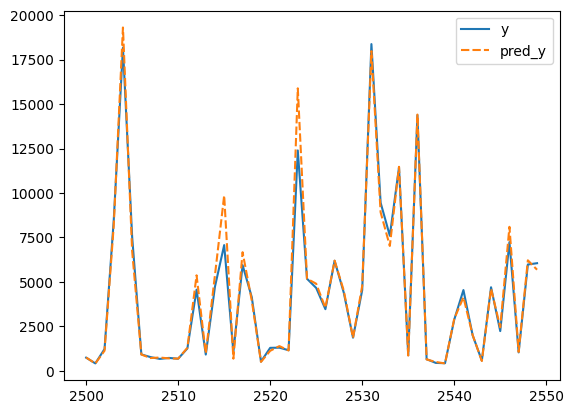

MAE of Neaural Network trained on logarythmic transformed data for plot below is : 304.82541320800783


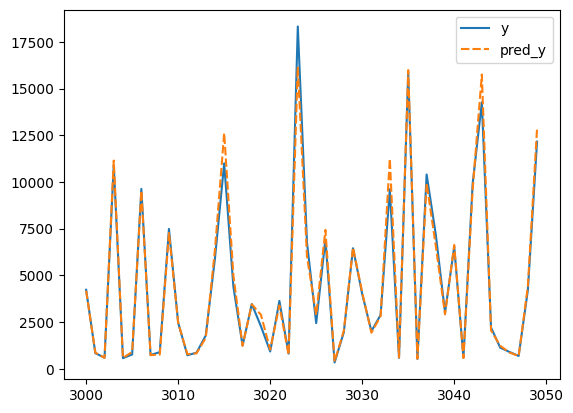

MAE of Neaural Network trained on logarythmic transformed data for plot below is : 297.1118957519531


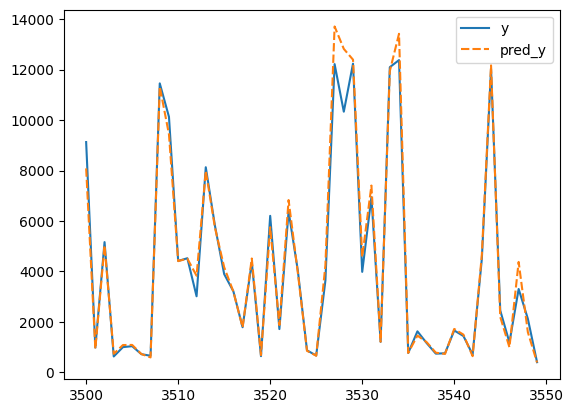

In [43]:
pred_y = np.exp(NN_model_log.predict(pipeline.transform(test_X)))
pred_df = pd.DataFrame(test_y.values,columns=["y"])
pred_df["pred_y"] = pred_y

print(f"MAE for all test data is {mean_absolute_error(test_y.values, pred_y)}")

for i in [1000,1500,2000,2500,3000,3500]:
  sns.lineplot(pred_df[i:i+50])
  print(f"MAE of Neaural Network trained on logarythmic transformed data for plot below is : {mean_absolute_error(test_y[i:i+50].values, pred_y[i:i+50])}")
  plt.show()

253/253 [==============================] - 1s 2ms/step
MAE for all test data is 257.25066262581817
MAE of Neaural Network trained on non logarythmic transformed data for plot below is : 225.11323303222656


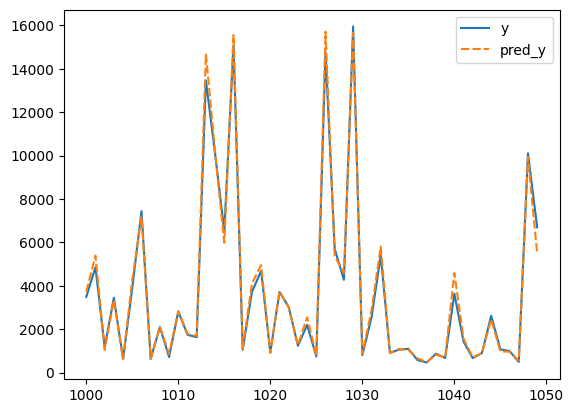

MAE of Neaural Network trained on non logarythmic transformed data for plot below is : 290.1343884277344


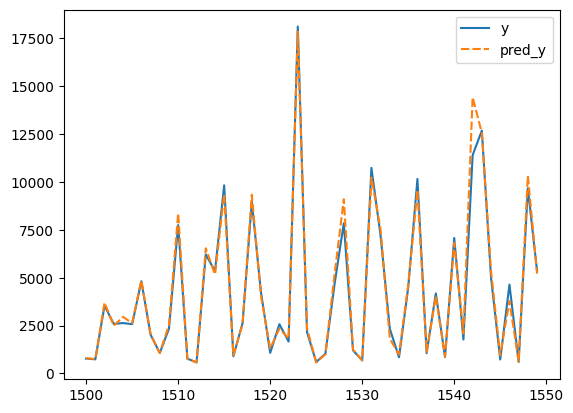

MAE of Neaural Network trained on non logarythmic transformed data for plot below is : 263.0925988769531


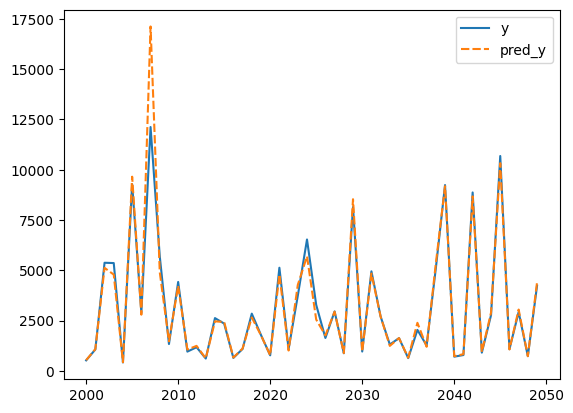

MAE of Neaural Network trained on non logarythmic transformed data for plot below is : 326.42412353515624


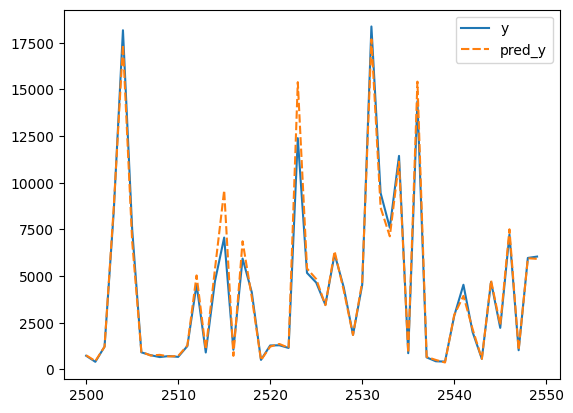

MAE of Neaural Network trained on non logarythmic transformed data for plot below is : 324.1405645751953


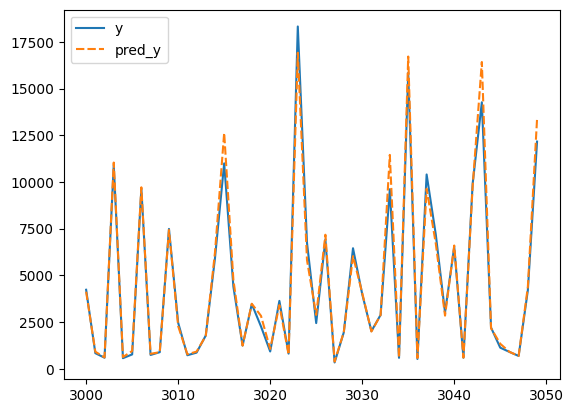

MAE of Neaural Network trained on non logarythmic transformed data for plot below is : 326.1596990966797


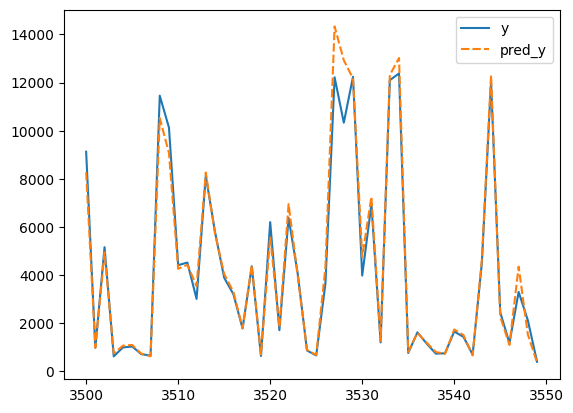

In [24]:
NN_model = joblib.load("/content/diamond_neural_network.pkl")

pred_y = NN_model.predict(pipeline.transform(test_X))
pred_df = pd.DataFrame(test_y.values,columns=["y"])
pred_df["pred_y"] = pred_y

print(f"MAE for all test data is {mean_absolute_error(test_y.values, pred_y)}")

for i in [1000,1500,2000,2500,3000,3500]:
  sns.lineplot(pred_df[i:i+50])
  print(f"MAE of Neaural Network trained on non logarythmic transformed data for plot below is : {mean_absolute_error(test_y[i:i+50].values, pred_y[i:i+50])}")
  plt.show()

253/253 [==============================] - 1s 4ms/step
MAE for all test data is 257.25066262581817


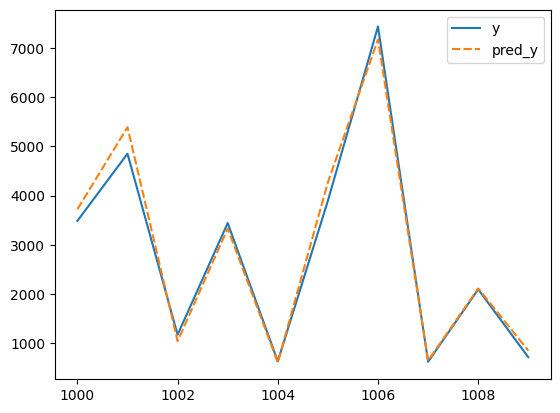

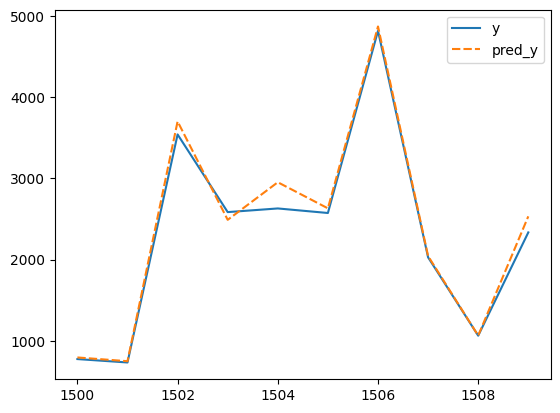

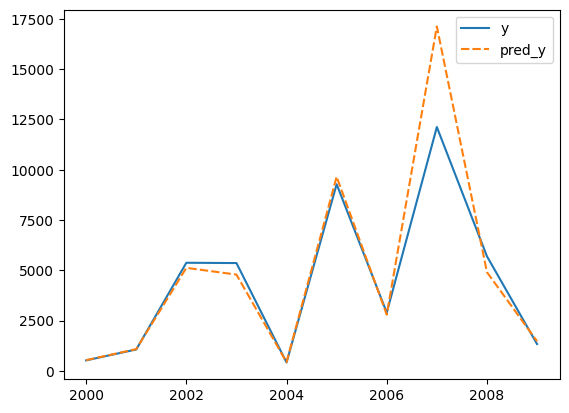

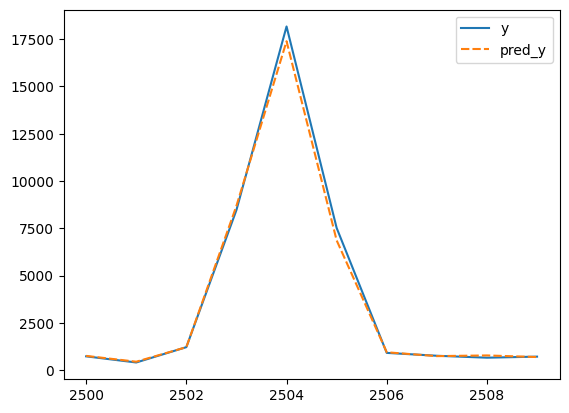

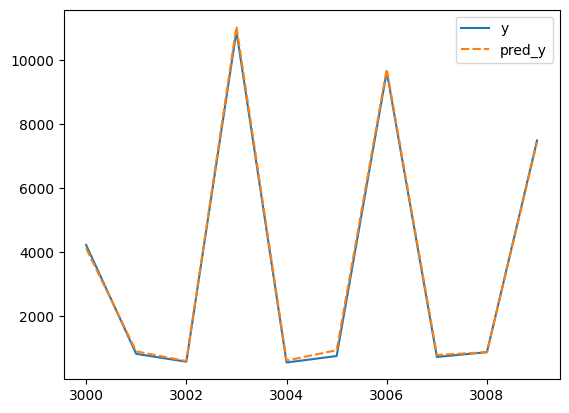

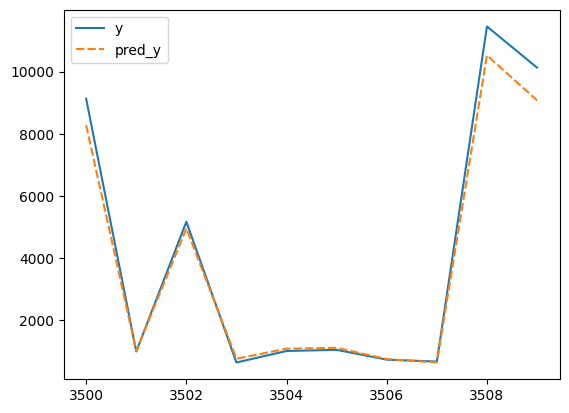

In [25]:
pred_y = NN_model.predict(pipeline.transform(test_X))
pred_df = pd.DataFrame(test_y.values,columns=["y"])
pred_df["pred_y"] = pred_y

print(f"MAE for all test data is {mean_absolute_error(test_y.values, pred_y)}")

for i in [1000,1500,2000,2500,3000,3500]:
  sns.lineplot(pred_df[i:i+10])
  plt.show()

MAE for all test data is 287.5623723751934
MAE of Neaural Network trained on non logarythmic transformed data for plot below is : 242.33425048828124


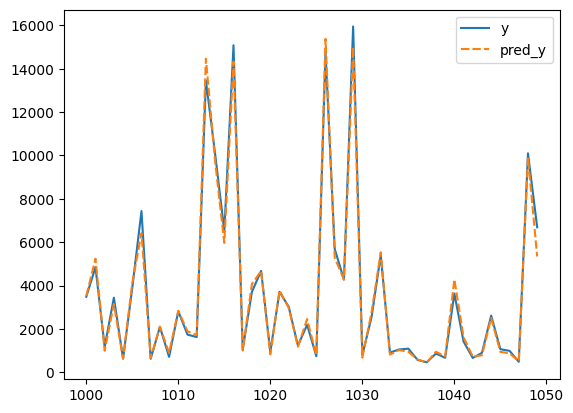

MAE of Neaural Network trained on non logarythmic transformed data for plot below is : 364.33199584960937


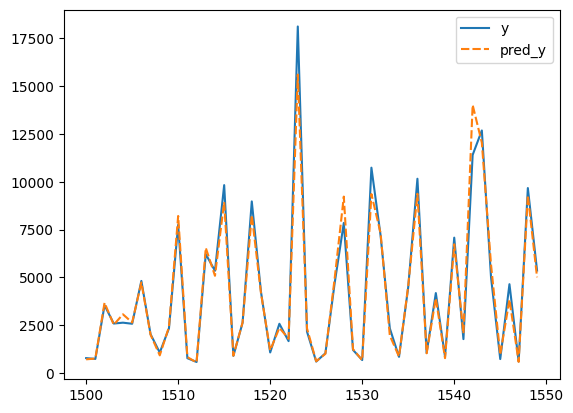

MAE of Neaural Network trained on non logarythmic transformed data for plot below is : 274.6553967285156


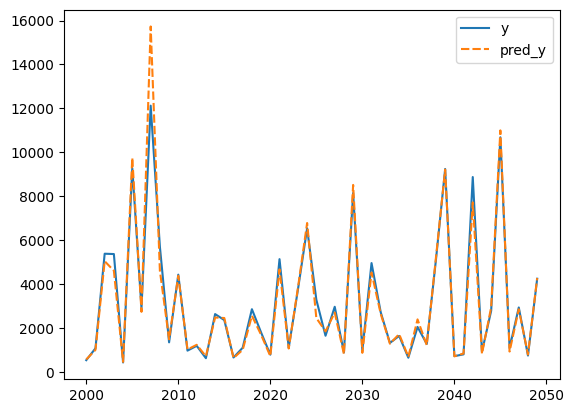

MAE of Neaural Network trained on non logarythmic transformed data for plot below is : 357.73511962890626


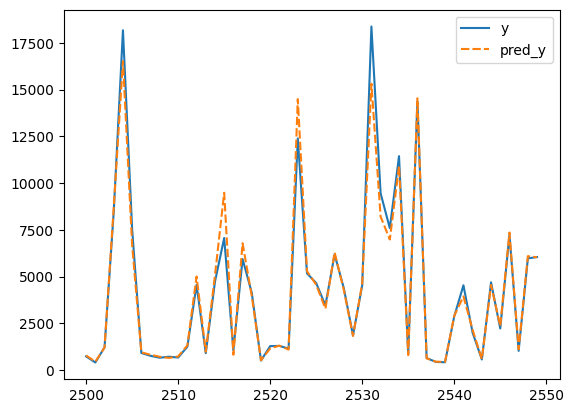

MAE of Neaural Network trained on non logarythmic transformed data for plot below is : 358.30151306152345


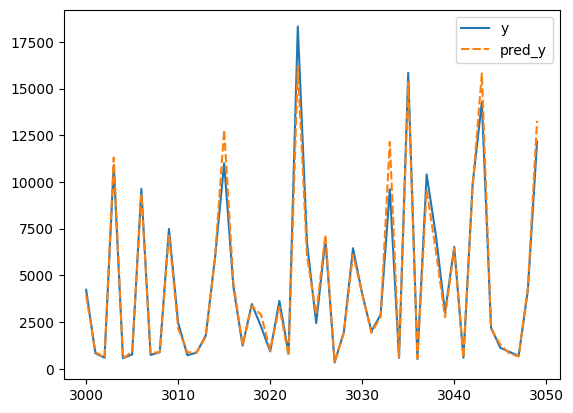

MAE of Neaural Network trained on non logarythmic transformed data for plot below is : 342.8160400390625


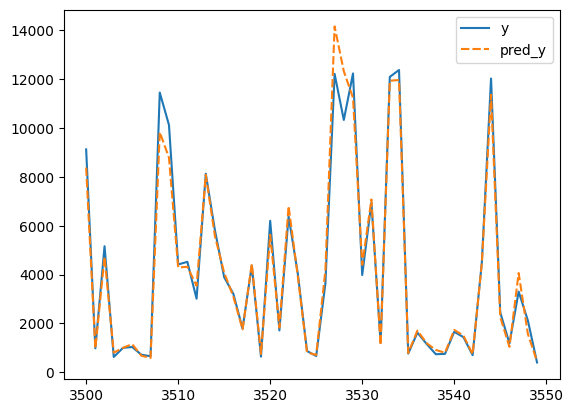

In [51]:
xgb_reg = XGBRegressor(learning_rate=0.05)
xgb_reg.fit(prepared_train_X,log_train_y)

pred_y = np.exp(xgb_reg.predict(pipeline.transform(test_X)))
pred_df = pd.DataFrame(test_y.values,columns=["y"])
pred_df["pred_y"] = pred_y

print(f"MAE for all test data is {mean_absolute_error(test_y.values, pred_y)}")

for i in [1000,1500,2000,2500,3000,3500]:
  sns.lineplot(pred_df[i:i+50])
  print(f"MAE of Neaural Network trained on non logarythmic transformed data for plot below is : {mean_absolute_error(test_y[i:i+50].values, pred_y[i:i+50])}")
  plt.show()

save

In [52]:
joblib.dump(NN_model, "diamond_neural_network.pkl")
joblib.dump(xgb_reg, "diamond_xgbregressor.pkl")

['diamond_xgbregressor.pkl']

# TODO

In [ ]:
# TODO
#